In [193]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from prophet.plot import plot_cross_validation_metric

In [102]:
# Import train data
ne_train = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/ne_train.csv")
s_train = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/s_train.csv")

# Import test data
ne_test = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/ne_test.csv")
s_test = pd.read_csv("/Users/Huey.ts/Desktop/STAT_390/data/s_test.csv")

In [103]:
ne_train_transformed = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_transformed = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [104]:
s_train_transformed = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_transformed = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [105]:
ne_train_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
ne_test_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

In [106]:
s_train_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)
s_test_transformed.rename(columns = {"date":"ds", "covid_19_confirmed_cases":"y"}, inplace = True)

In [107]:
ne_train_plot = pd.merge(ne_train.date, ne_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
ne_test_plot = pd.merge(ne_test.date, ne_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

s_train_plot = pd.merge(s_train.date, s_train["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)
s_test_plot = pd.merge(s_test.date, s_test["covid_19_confirmed_cases"], 
                                left_index=True, right_index=True)

In [108]:
ne_train_plot.set_index("date", inplace = True)
ne_test_plot.set_index("date", inplace = True)

s_train_plot.set_index("date", inplace = True)
s_test_plot.set_index("date", inplace = True)

# Prophet Model
- Model time series data as a combination of trend, seasonality, and noise components

## Normal Prophet
- Both models performed way worse than ARIMA and AutoARIMA models
- NE: MAE = 3196 confirmed cases
    - Severe under fitting
        - Trend in the train set is unpredictable
    - Changepoints correctly captured by the standard model --> add more changepoints
    - Did not correctly capture the trend --> negative predicted values on test set
- S: MAE = 26646 confirmed cases
    - Very goot fit (not under or over fitting)
        - Trend in the train set is quite predictable --> increasing
    - Changepoints correctly captured by the standard model --> add more changepoints
    - Did not correctly capture the trend in the test set

### NE Region

In [156]:
ne_normal_prophet = Prophet()

In [157]:
ne_normal_prophet.fit(ne_train_transformed)

11:44:28 - cmdstanpy - INFO - Chain [1] start processing
11:44:28 - cmdstanpy - INFO - Chain [1] done processing


In [158]:
ne_normal_future = ne_normal_prophet.make_future_dataframe(periods=ne_test_transformed.shape[0])

In [159]:
ne_normal_forecast = ne_normal_prophet.predict(ne_normal_future)

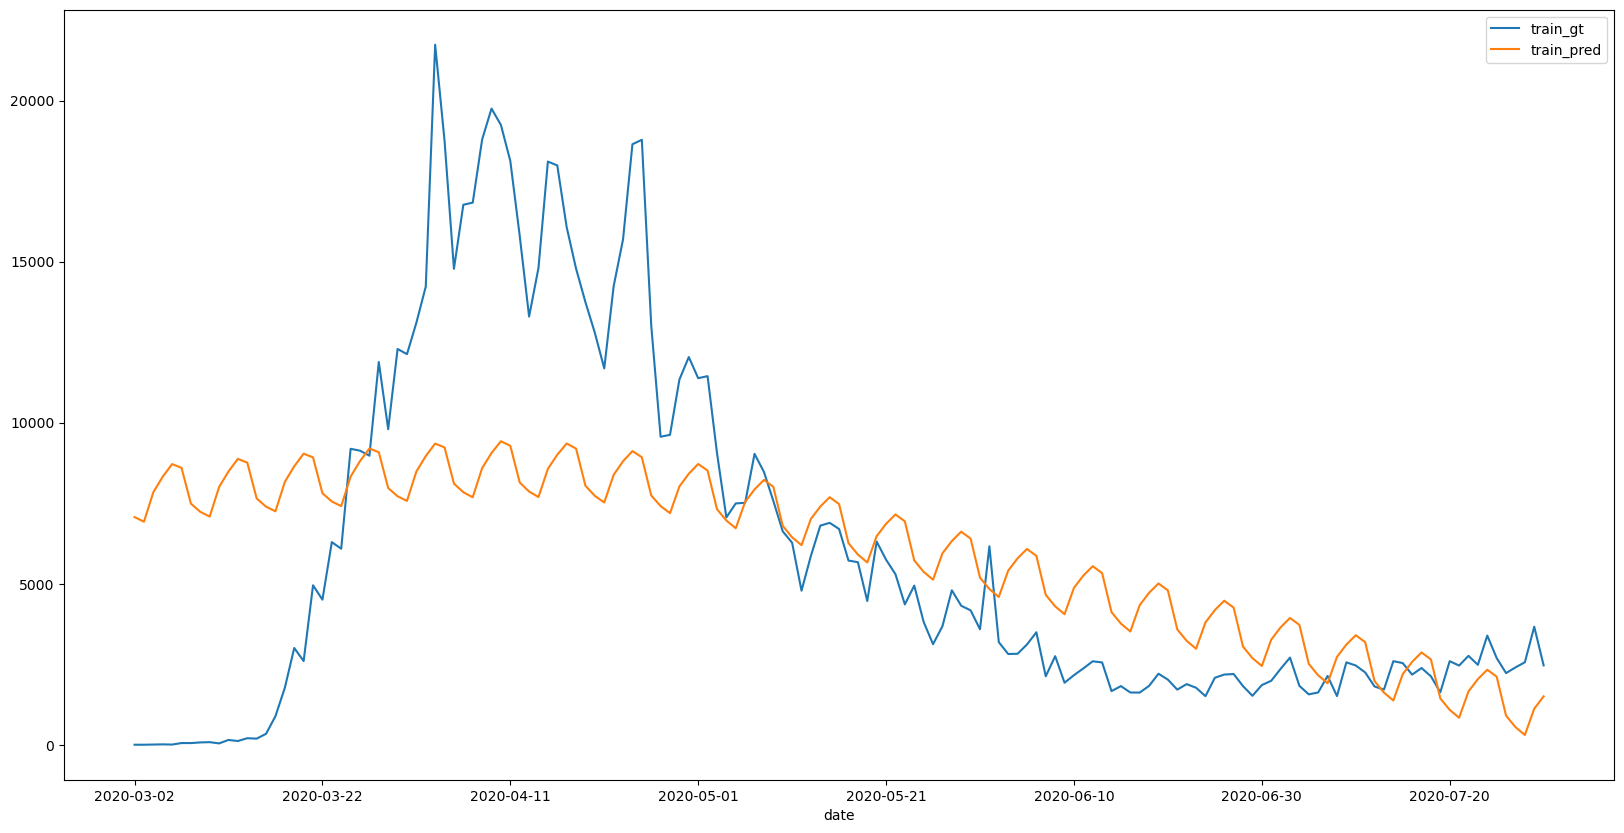

In [160]:
# Visualizing train data fitted values
ne_train_pred = ne_normal_forecast.iloc[:151]["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

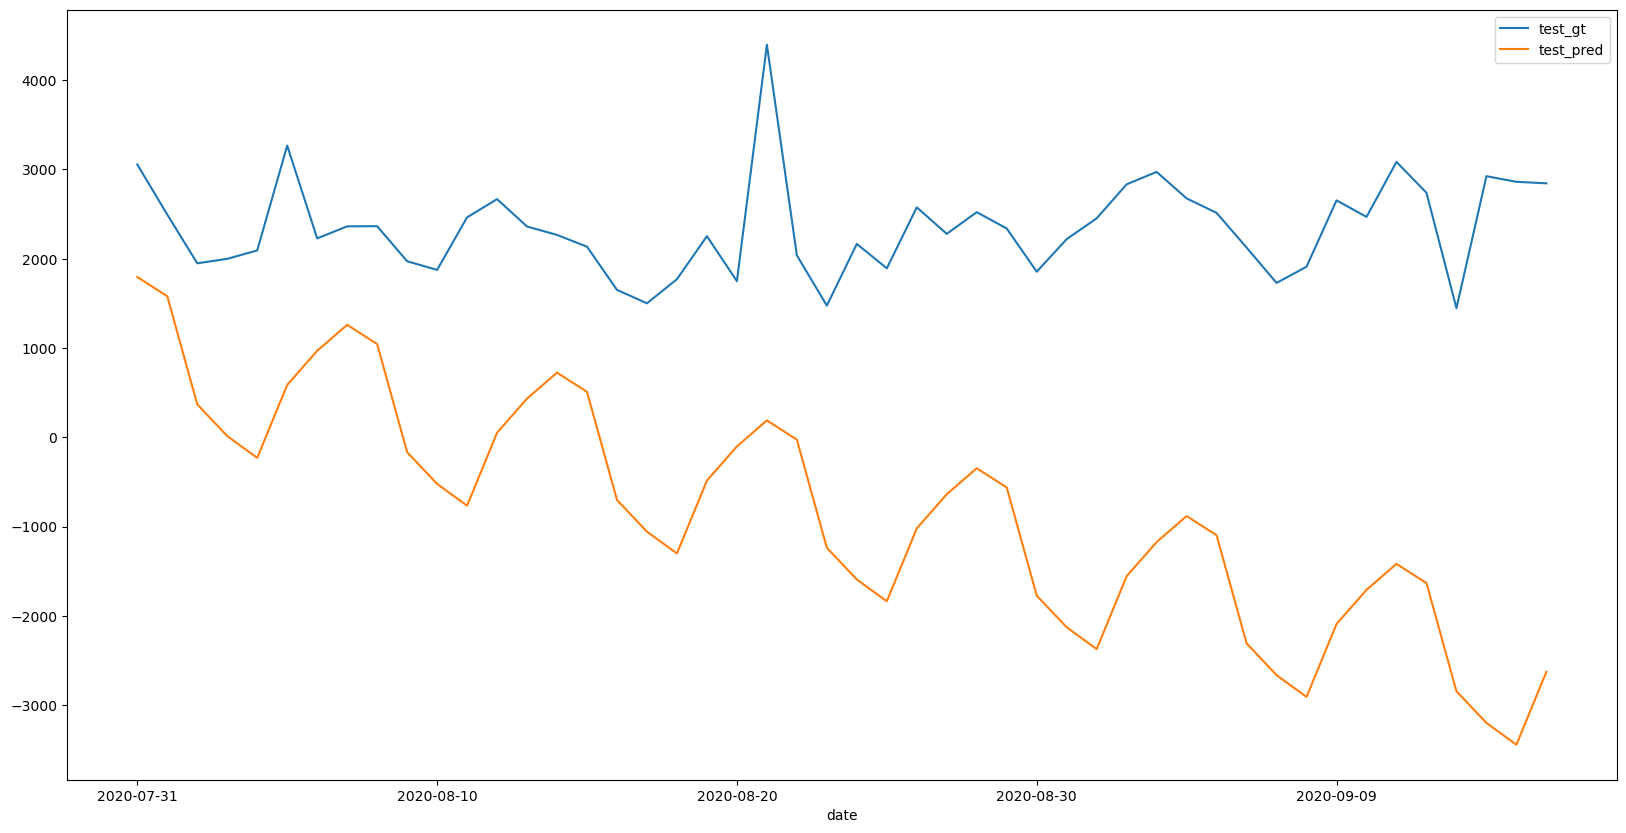

In [161]:
# Visualizing test data fitted values
ne_test_pred = ne_normal_forecast.iloc[151:]["yhat"]
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [162]:
# MAE
mean_absolute_error(ne_test_plot, ne_test_pred)

3196.0898131578956

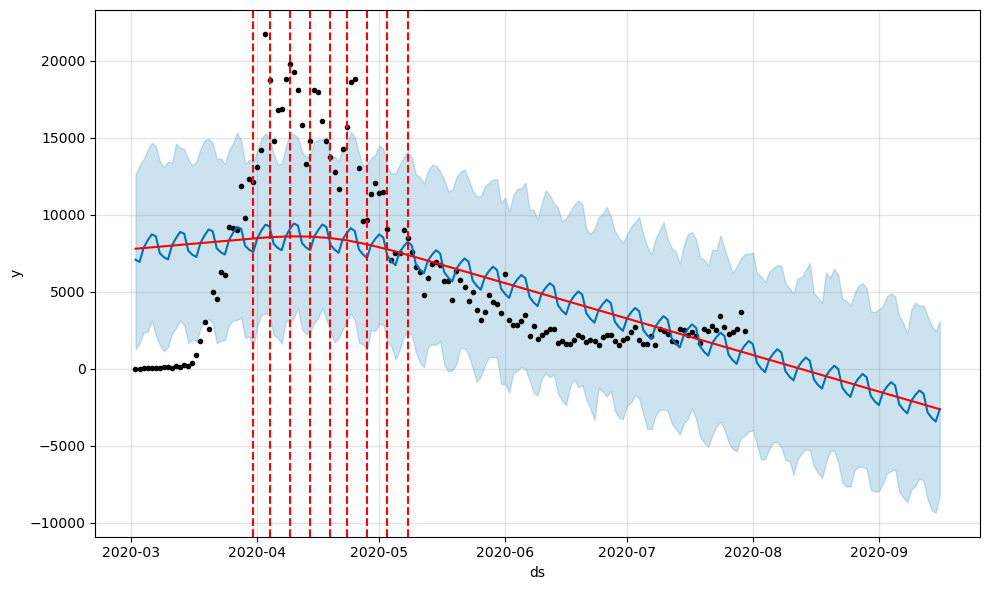

In [163]:
# Visualizing change points
fig = ne_normal_prophet.plot(ne_normal_forecast)
a = add_changepoints_to_plot(fig.gca(), ne_normal_prophet, ne_normal_forecast)

### S Region

In [164]:
s_normal_prophet = Prophet()

In [165]:
s_normal_prophet.fit(s_train_transformed)

11:44:36 - cmdstanpy - INFO - Chain [1] start processing
11:44:36 - cmdstanpy - INFO - Chain [1] done processing


In [166]:
s_normal_future = s_normal_prophet.make_future_dataframe(periods=s_test_transformed.shape[0])

In [167]:
s_normal_forecast = s_normal_prophet.predict(s_normal_future)

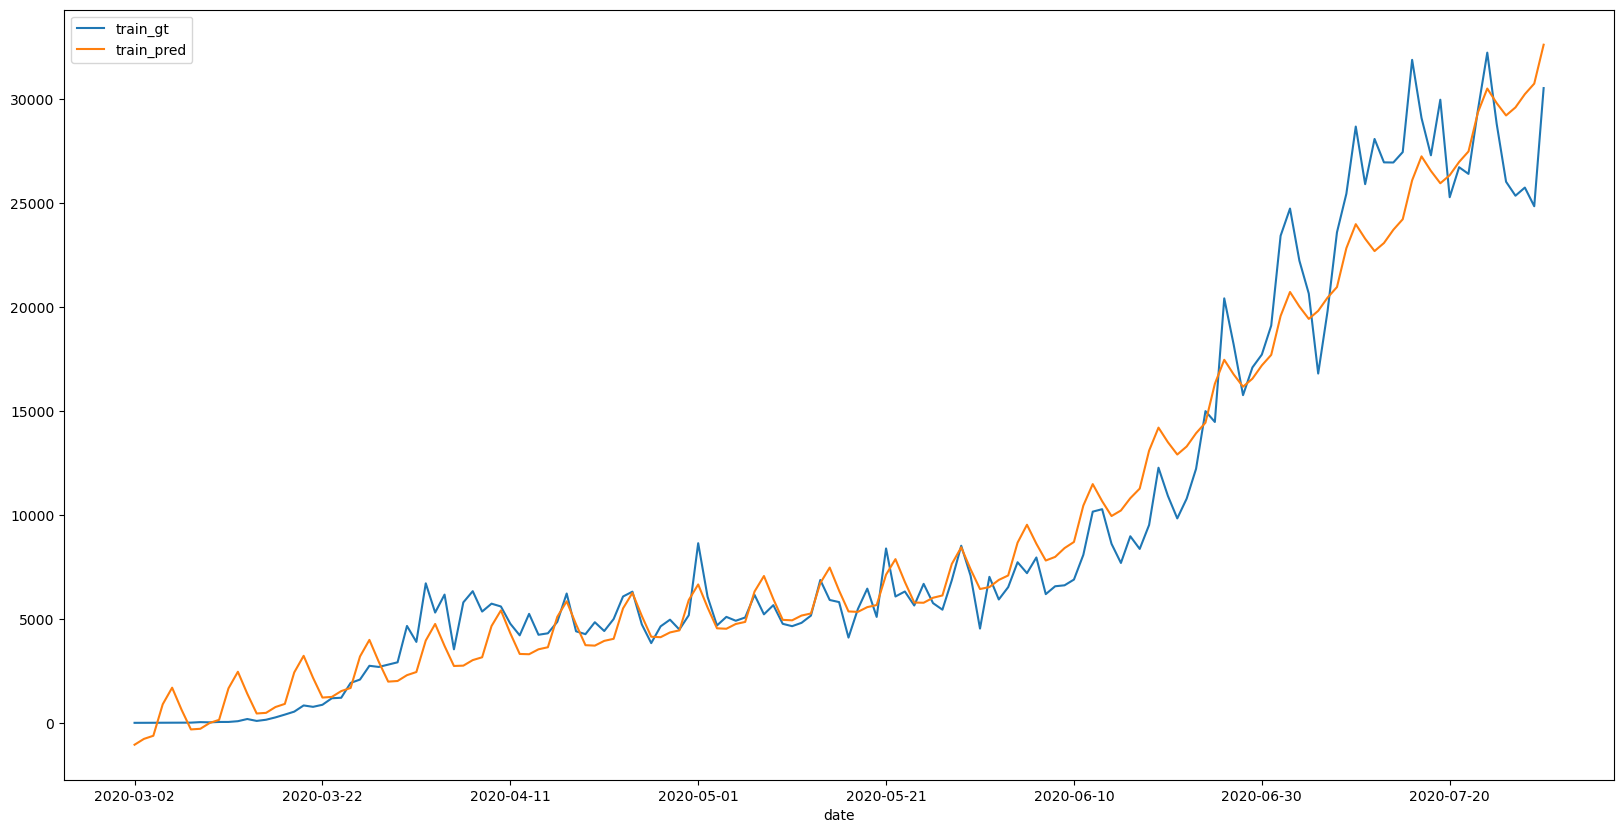

In [168]:
# Visualizing train data fitted values
s_train_pred = s_normal_forecast.iloc[:151]["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

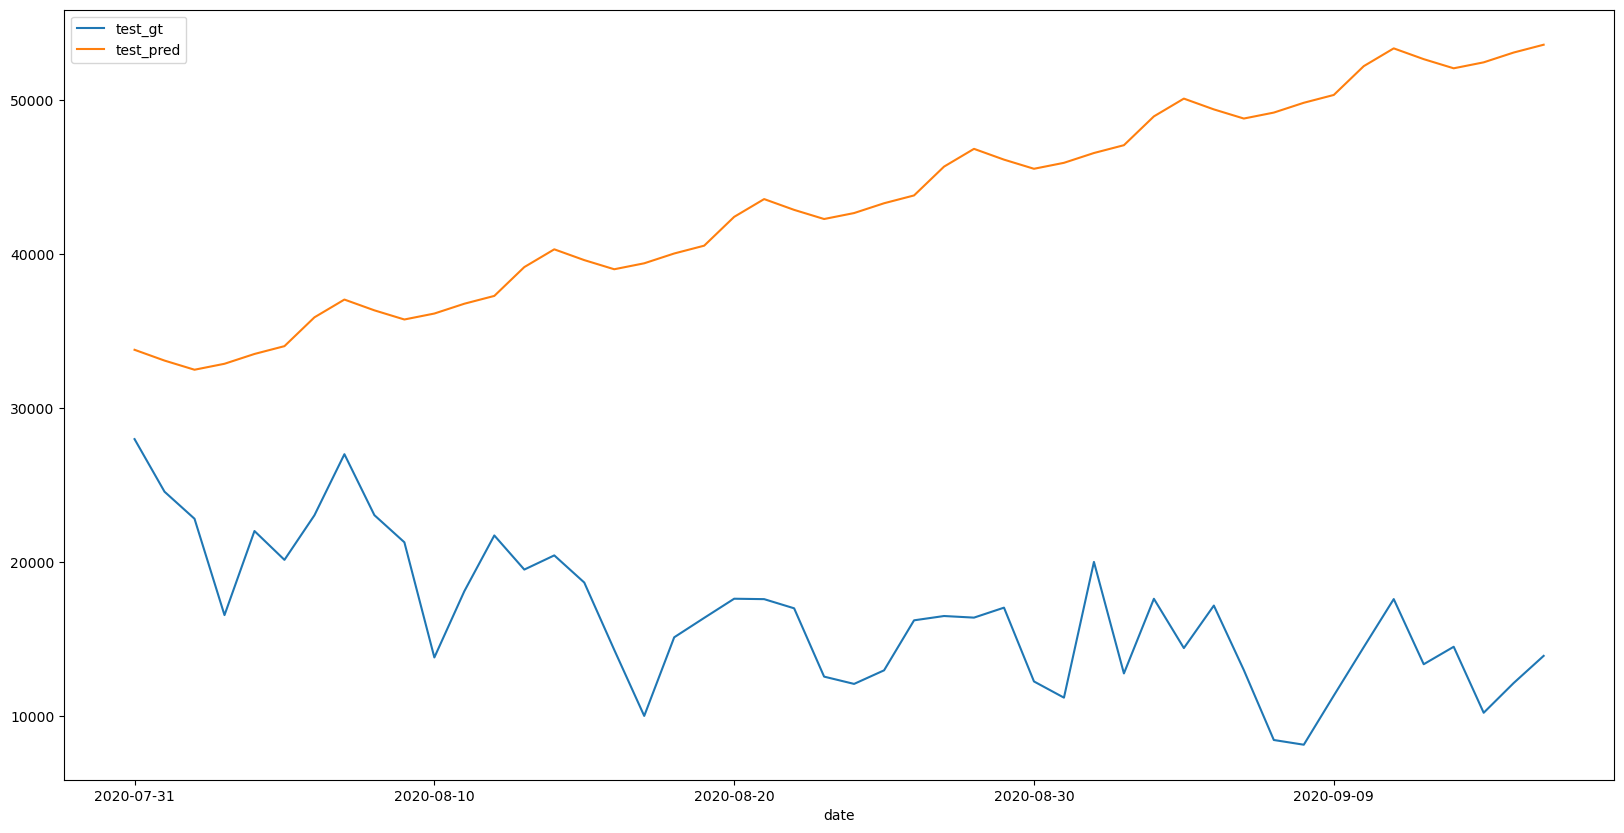

In [169]:
# Visualizing test data fitted values
s_test_pred = s_normal_forecast.iloc[151:]["yhat"]
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [170]:
# MAE
mean_absolute_error(s_test_plot, s_test_pred)

26646.907881599942

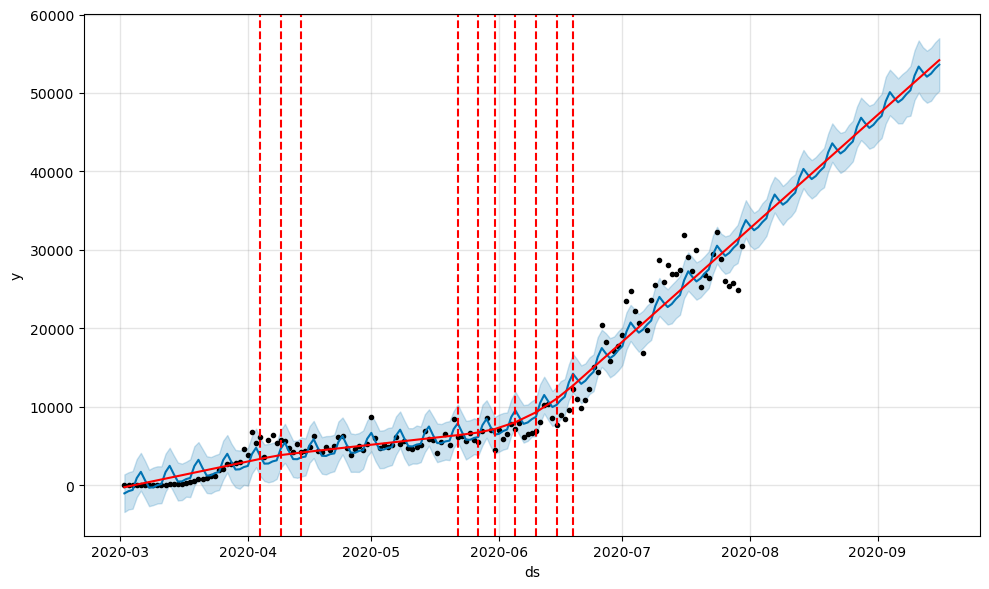

In [171]:
# Visualizing change points
fig = s_normal_prophet.plot(s_normal_forecast)
a = add_changepoints_to_plot(fig.gca(), s_normal_prophet, s_normal_forecast)

## Tuned Prophet
- Change changepoint proportion (Prophet has automatic 25 change points, which are uniformly placed in the first 80% of the time series)
    - This is the proportion of the history in which the trend is allowed to change
    - This defaults to 0.8, 80% of the history, meaning the model will not fit any trend changes in the last 20% of the time series
    - Change for S region only
    - changepoint_range
- Make trends more flexible --> capture later trends in the test set
    - changepoint_prior_scale=0.5
- Control the flexibility of the seasonality
    - seasonality_prior_scale
    - A large value allows the seasonality to fit large fluctuations
    - A small value shrinks the magnitude of the seasonality
- Add built-in US holidays

### Using Cross-Validation
- The initial model will be trained on the first 90 days of data
- It will forecast the next 30 days of data
- The model will then train on the initial period + the period (90 + 15 days) and forecast the next 30 days

### Results
- NE: MAE = 955 confirmed cases
    - No change point range
    - Way better fit on training data
    - More accurate prediction on testing data
- S: MAE = 8203 confirmed cases
    - changepoint_range = 1.0 --> Helps the model performance alot!
    - Fit on train data is as good as the normal model
    - Way better prediction on testing data; way better than AutoARIMA

### NE Region

In [327]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.6, 0.7],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

In [328]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
ne_maes = []

In [329]:
# Use cross validation to evaluate all parameters
for params in all_params:
    ne_tuned_prophet = Prophet(**params)
    ne_tuned_prophet.add_country_holidays(country_name='US')
    ne_tuned_prophet.fit(ne_train_transformed) 
    
    df_cv = cross_validation(ne_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    ne_maes.append(df_p["mae"].values[0])

22:16:08 - cmdstanpy - INFO - Chain [1] start processing
22:16:08 - cmdstanpy - INFO - Chain [1] done processing
22:16:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:16:08 - cmdstanpy - INFO - Chain [1] start processing
22:16:08 - cmdstanpy - INFO - Chain [1] done processing
22:16:09 - cmdstanpy - INFO - Chain [1] start processing
22:16:09 - cmdstanpy - INFO - Chain [1] start processing
22:16:09 - cmdstanpy - INFO - Chain [1] start processing
22:16:09 - cmdstanpy - INFO - Chain [1] done processing
22:16:09 - cmdstanpy - INFO - Chain [1] done processing
22:16:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
22:16:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
22:16:09 - cmdstanpy - 

22:16:19 - cmdstanpy - INFO - Chain [1] done processing
22:16:19 - cmdstanpy - INFO - Chain [1] start processing
22:16:19 - cmdstanpy - INFO - Chain [1] done processing
22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:20 - cmdstanpy - INFO - Chain [1] done processing
22:16:20 - cmdstanpy - INFO - Chain [1] done processing
22:16:20 - cmdstanpy - INFO - Chain [1] done processing
22:16:20 - cmdstanpy - INFO - Chain [1] start processing
22:16:20 - cmdstanpy - INFO - Chain [1] done processing
22:16:21 - cmdstanpy - INFO - Chain [1] start processing
22:16:21 - cmdstanpy - INFO - Chain [1] start processing
22:16:21 - cmdstanpy - INFO - Chain [1] start processing
22:16:21 - cmdstanpy - INFO - Chain [1] done processing
22:16:21 - cmdstanpy - INFO - Chain [1] done processing
22:16:21 - cmdstanpy - INFO - Chain [1] done processing
22:16:21 - cmdstanpy - INFO - Chain [1] 

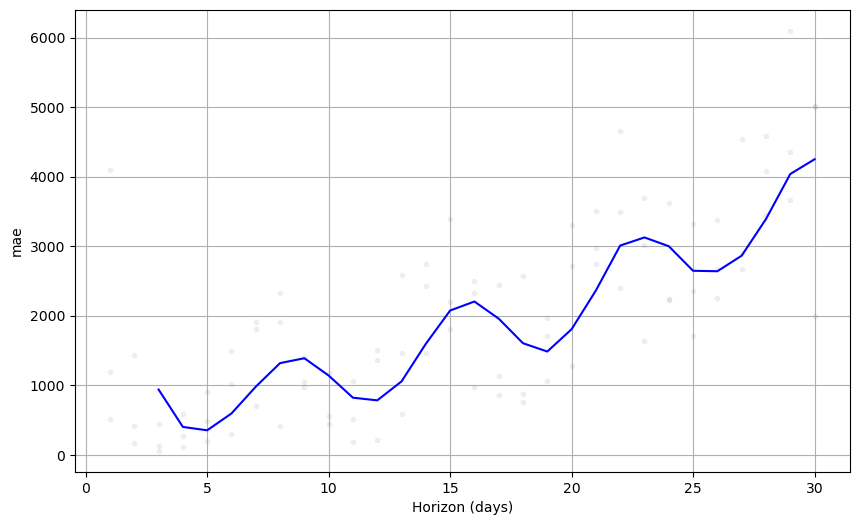

In [330]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [331]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mae"] = ne_maes
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale          mae
0                     0.001                     0.01  4351.483173
1                     0.001                     0.10  4271.852469
2                     0.001                     1.00  4361.723886
3                     0.001                    10.00  4352.758426
4                     0.010                     0.01  5522.612728
5                     0.010                     0.10  6114.650045
6                     0.010                     1.00  5534.254299
7                     0.010                    10.00  5504.752601
8                     0.100                     0.01  2012.442019
9                     0.100                     0.10  2039.745209
10                    0.100                     1.00  2083.749080
11                    0.100                    10.00  2012.899699
12                    0.500                     0.01   847.665337
13                    0.500                     0.10   946.365711
14        

In [332]:
# Find the best hyperparameter
best_params = all_params[np.argmin(ne_maes)]
print(best_params)

{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 0.01}


### NE Region Model

In [333]:
ne_tuned_prophet = Prophet(changepoint_prior_scale = 0.7,
                           seasonality_prior_scale = 0.01)
ne_tuned_prophet.add_country_holidays(country_name='US')

In [334]:
ne_tuned_prophet.fit(ne_train_transformed) 

22:16:46 - cmdstanpy - INFO - Chain [1] start processing
22:16:46 - cmdstanpy - INFO - Chain [1] done processing


In [335]:
ne_tuned_future = ne_tuned_prophet.make_future_dataframe(periods=ne_test_transformed.shape[0])

In [336]:
ne_tuned_forecast = ne_tuned_prophet.predict(ne_tuned_future)

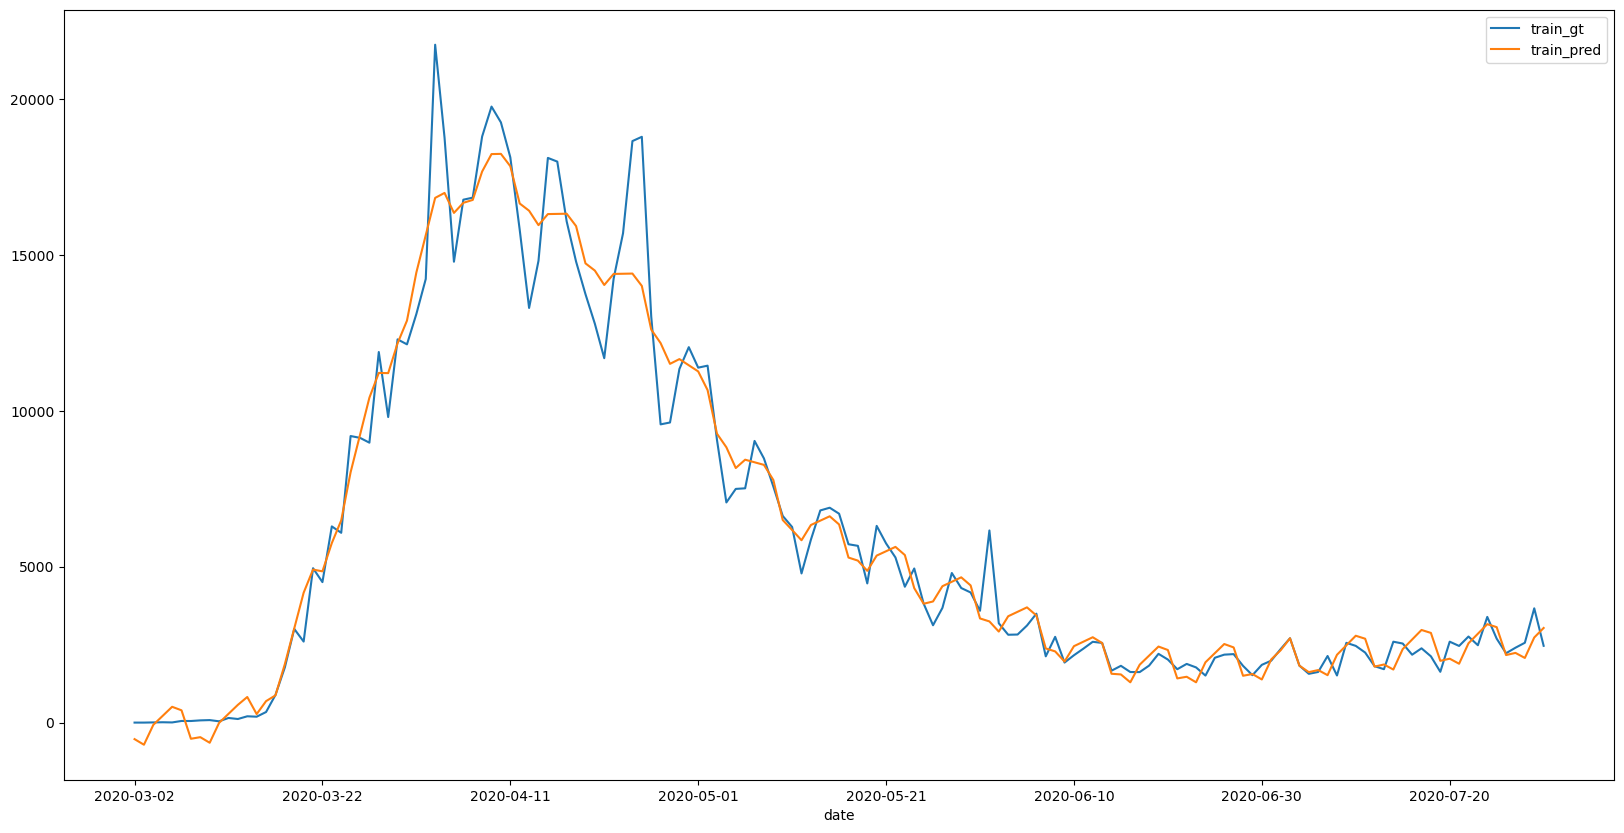

In [337]:
# Visualizing train data fitted values
ne_train_pred = ne_tuned_forecast.iloc[:151]["yhat"]
ne_train_pred.index = ne_train_plot.index
pd.concat([ne_train_plot, ne_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

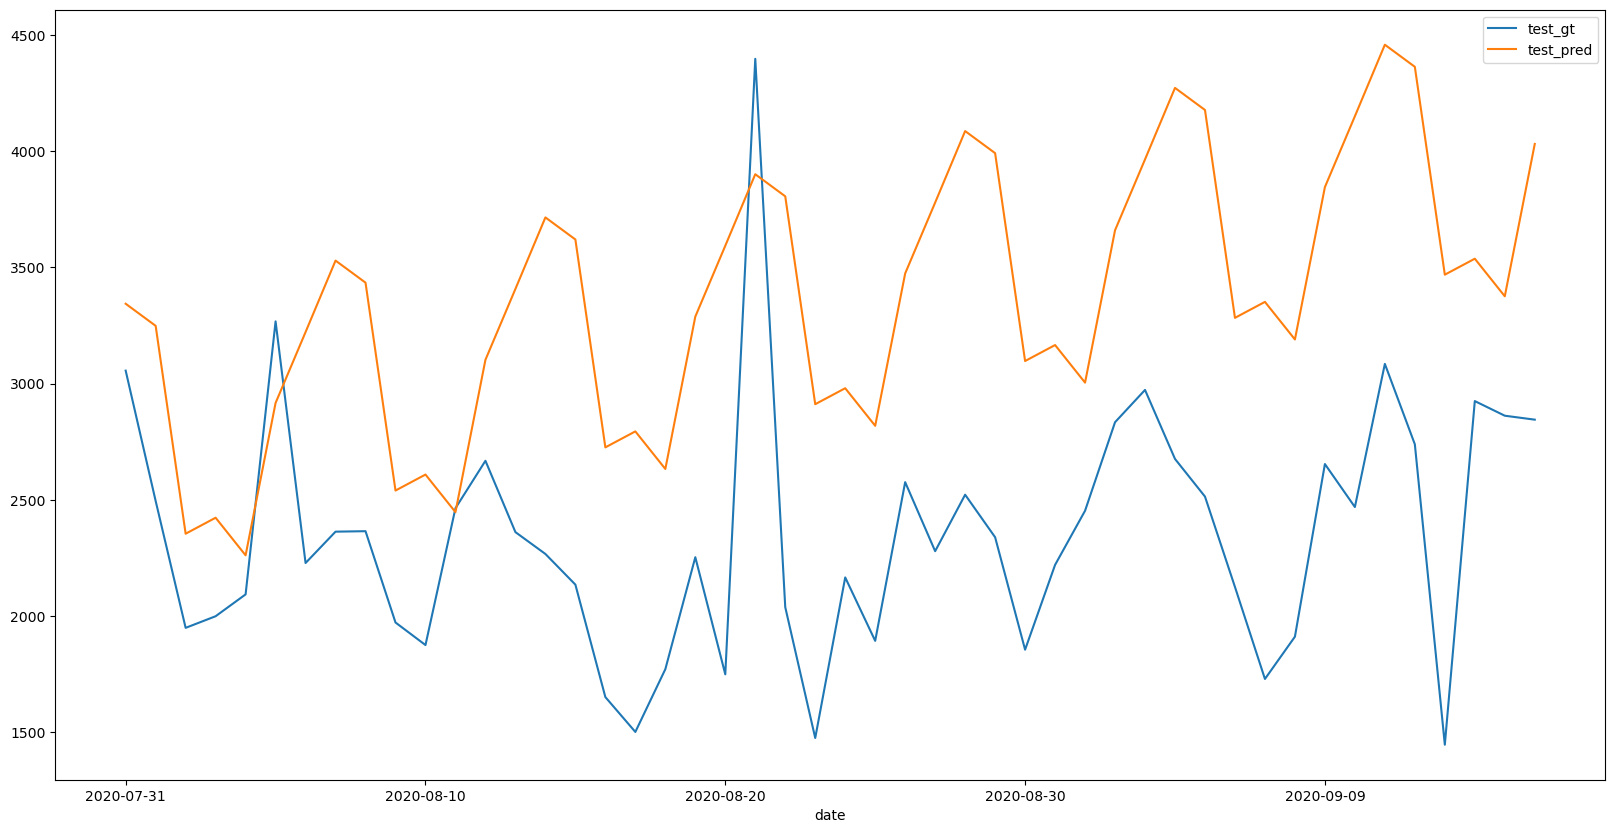

In [338]:
# Visualizing test data fitted values
ne_test_pred = ne_tuned_forecast.iloc[151:]["yhat"]
ne_test_pred.index = ne_test_plot.index
pd.concat([ne_test_plot, ne_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [339]:
# MAE
mean_absolute_error(ne_test_plot, ne_test_pred)

1054.3707267533962

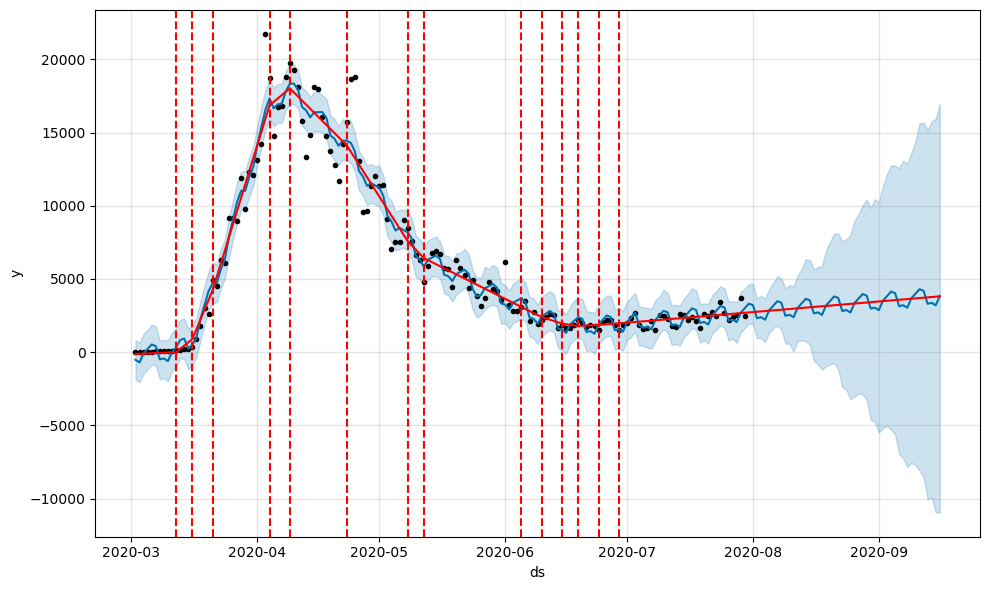

In [283]:
# Visualizing change points
fig = ne_tuned_prophet.plot(ne_tuned_forecast)
a = add_changepoints_to_plot(fig.gca(), ne_tuned_prophet, ne_tuned_forecast)

### S Region

In [312]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 0.6, 0.7, 0.8, 0.9],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'changepoint_range': [0.8, 0.9, 1.0]
}

In [313]:
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
s_maes = []

In [314]:
# Use cross validation to evaluate all parameters
for params in all_params:
    s_tuned_prophet = Prophet(**params)
    s_tuned_prophet.add_country_holidays(country_name='US')
    s_tuned_prophet.fit(s_train_transformed) 
    
    df_cv = cross_validation(s_tuned_prophet, initial='90 days', 
                             period='15 days', horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    s_maes.append(df_p["mae"].values[0])

19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing
19:17:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:17:54 - cmdstanpy - INFO - Chain [1] start processing
19:17:54 - cmdstanpy - INFO - Chain [1] done processing
19:17:55 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] start processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:55 - cmdstanpy - INFO - Chain [1] done processing
19:17:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
19:17:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
19:17:55 - cmdstanpy - 

19:18:01 - cmdstanpy - INFO - Chain [1] done processing
19:18:01 - cmdstanpy - INFO - Chain [1] start processing
19:18:01 - cmdstanpy - INFO - Chain [1] done processing
19:18:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:01 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing
19:18:02 - cmdstanpy - ERROR - Chain [1] error: error during proce

19:18:09 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:10 - cmdstanpy - INFO - Chain [1] start processing
19:18:10 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:11 - cmdstanpy - INFO - Chain [1] start processing
19:18:11 - cmdstanpy - INFO - Chain [1] done processing
19:18:12 - cmdstanpy - INFO - Chain [1] 

19:18:25 - cmdstanpy - INFO - Chain [1] done processing
19:18:25 - cmdstanpy - INFO - Chain [1] start processing
19:18:25 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] done processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:26 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] start processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] done processing
19:18:27 - cmdstanpy - INFO - Chain [1] 

19:18:42 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:43 - cmdstanpy - INFO - Chain [1] start processing
19:18:43 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:44 - cmdstanpy - INFO - Chain [1] start processing
19:18:44 - cmdstanpy - INFO - Chain [1] done processing
19:18:45 - cmdstanpy - INFO - Chain [1] 

19:19:00 - cmdstanpy - INFO - Chain [1] start processing
19:19:00 - cmdstanpy - INFO - Chain [1] done processing
19:19:01 - cmdstanpy - INFO - Chain [1] start processing
19:19:01 - cmdstanpy - INFO - Chain [1] start processing
19:19:01 - cmdstanpy - INFO - Chain [1] start processing
19:19:01 - cmdstanpy - INFO - Chain [1] done processing
19:19:01 - cmdstanpy - INFO - Chain [1] done processing
19:19:01 - cmdstanpy - INFO - Chain [1] done processing
19:19:01 - cmdstanpy - INFO - Chain [1] start processing
19:19:01 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] done processing
19:19:02 - cmdstanpy - INFO - Chain [1] start processing
19:19:02 - cmdstanpy - INFO - Chain [1]

19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] start processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:18 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] start processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:19 - cmdstanpy - INFO - Chain [1] done processing
19:19:20 - cmdstanpy - INFO - Chain [1] done processing
19:19:20 - cmdstanpy - INFO - Chain [1] start processing
19:19:20 - cmdstanpy - INFO - Chain [1] done processing
19:19:20 - cmdstanpy - INFO - Chain [1] 

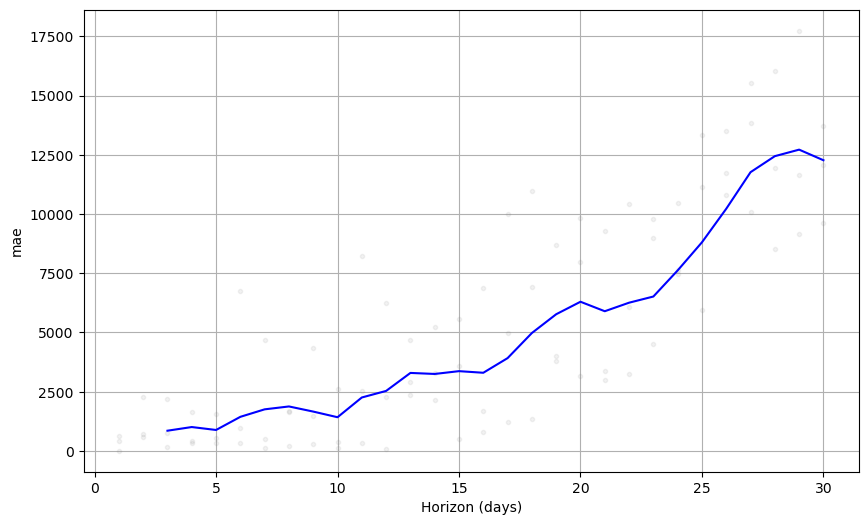

In [318]:
fig = plot_cross_validation_metric(df_cv, metric='mae')

In [319]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results["mae"] = s_maes
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale  changepoint_range  \
0                     0.001                     0.01                0.8   
1                     0.001                     0.01                0.9   
2                     0.001                     0.01                1.0   
3                     0.001                     0.10                0.8   
4                     0.001                     0.10                0.9   
..                      ...                      ...                ...   
91                    0.900                     1.00                0.9   
92                    0.900                     1.00                1.0   
93                    0.900                    10.00                0.8   
94                    0.900                    10.00                0.9   
95                    0.900                    10.00                1.0   

            mae  
0   4085.586184  
1   4085.829665  
2   4085.182982  
3   3968.615810  
4   3968.

In [320]:
# Find the best hyperparameter
best_params = all_params[np.argmin(s_maes)]
print(best_params)

{'changepoint_prior_scale': 0.6, 'seasonality_prior_scale': 0.01, 'changepoint_range': 1.0}


### S Region Model

In [304]:
s_tuned_prophet = Prophet(changepoint_prior_scale = 0.6,
                           seasonality_prior_scale = 0.01,
                         changepoint_range=1.0)
s_tuned_prophet.add_country_holidays(country_name='US')

In [305]:
s_tuned_prophet.fit(s_train_transformed) 

15:01:05 - cmdstanpy - INFO - Chain [1] start processing
15:01:05 - cmdstanpy - INFO - Chain [1] done processing


In [306]:
s_tuned_future = s_tuned_prophet.make_future_dataframe(periods=s_test_transformed.shape[0])

In [307]:
s_tuned_forecast = s_tuned_prophet.predict(s_tuned_future)

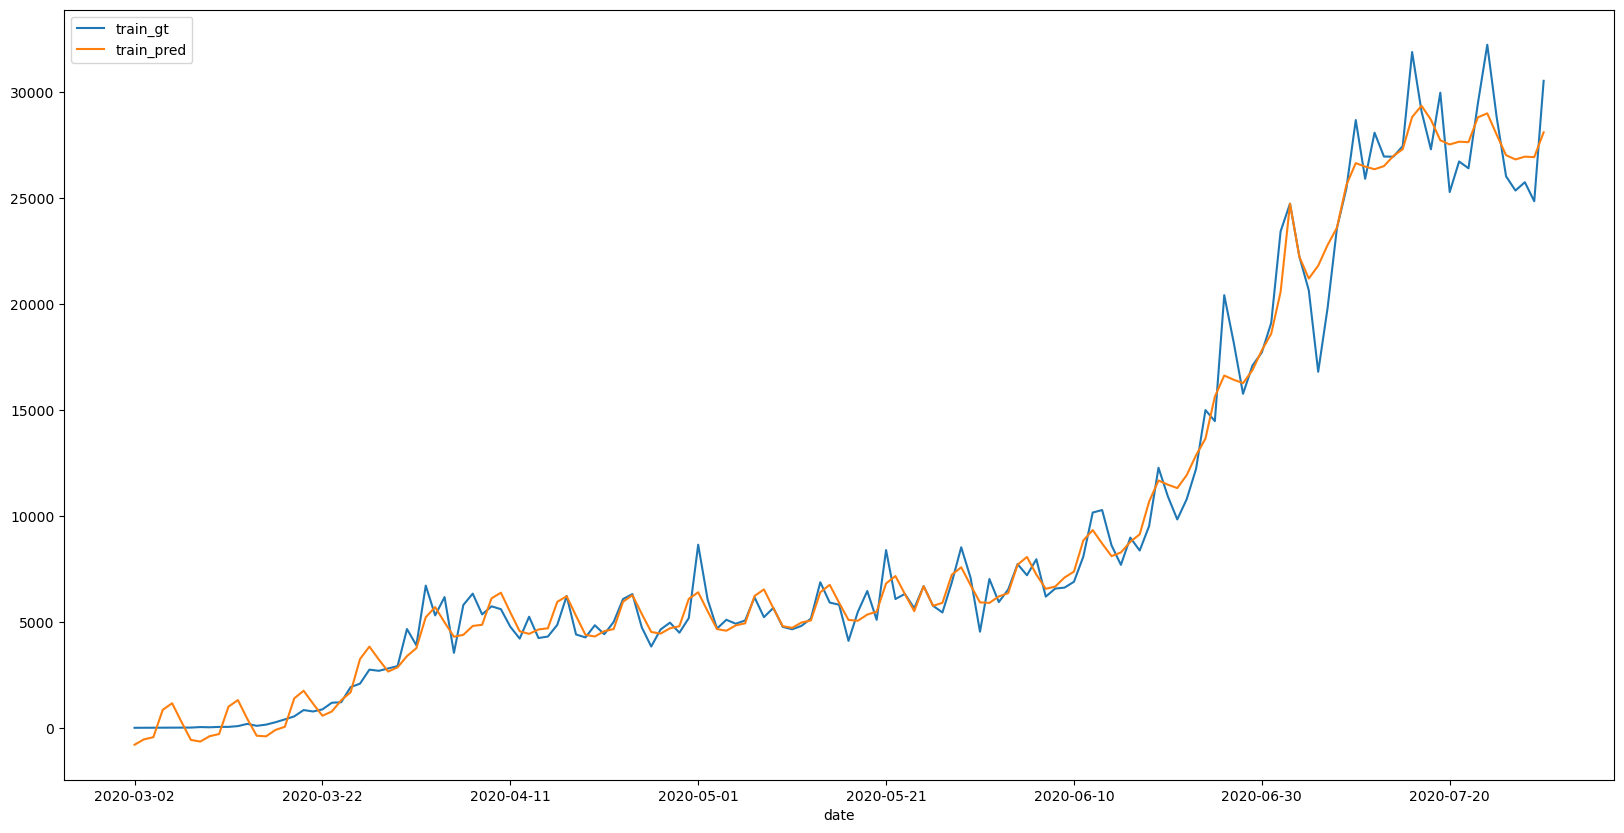

In [308]:
# Visualizing train data fitted values
s_train_pred = s_tuned_forecast.iloc[:151]["yhat"]
s_train_pred.index = s_train_plot.index
pd.concat([s_train_plot, s_train_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['train_gt', 'train_pred'])

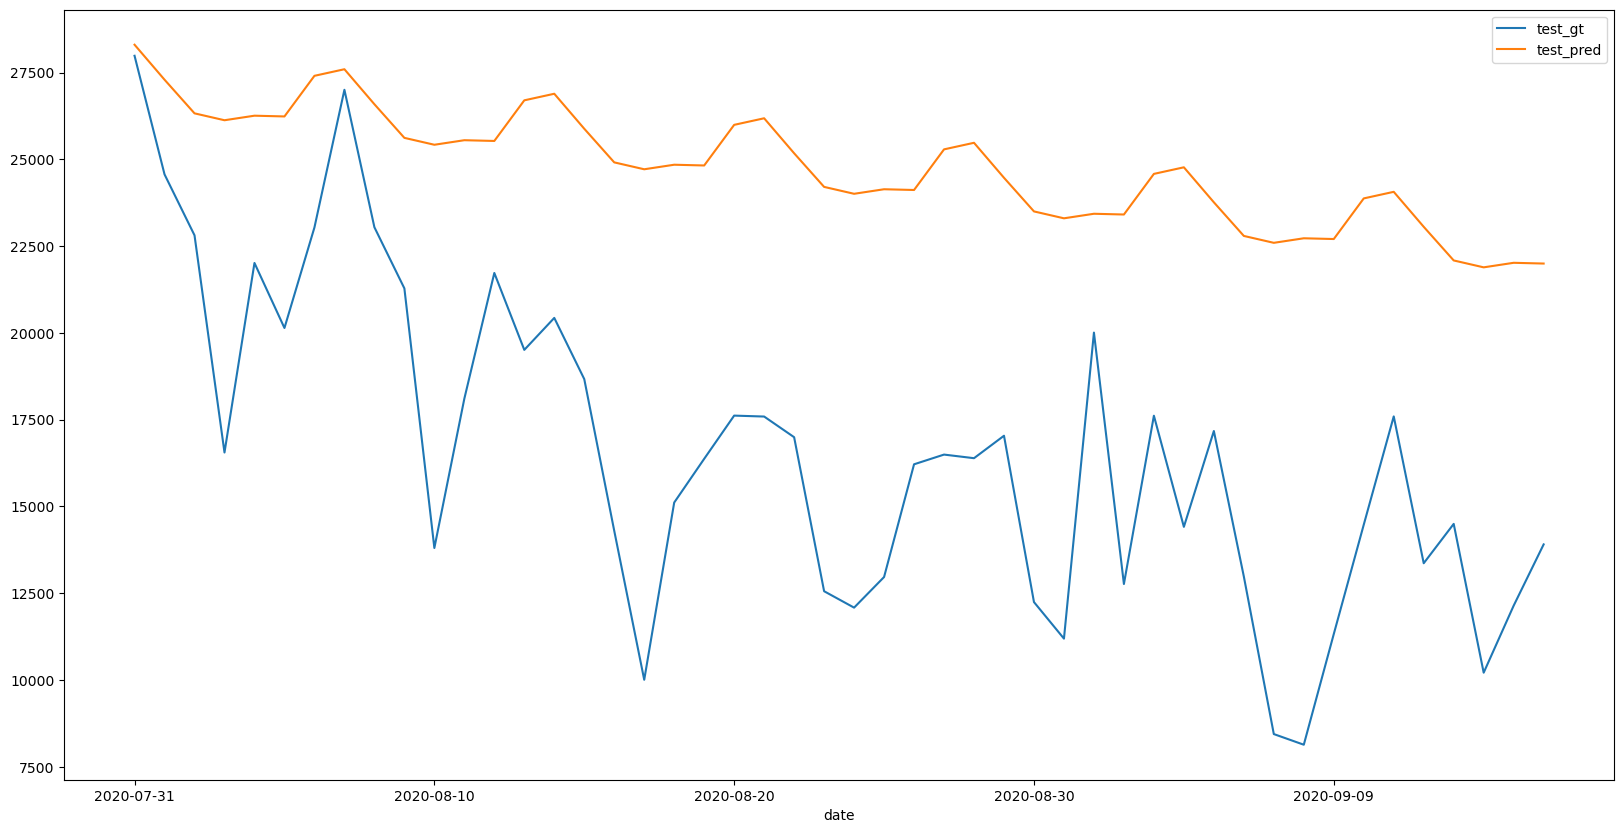

In [309]:
# Visualizing test data fitted values
s_test_pred = s_tuned_forecast.iloc[151:]["yhat"]
s_test_pred.index = s_test_plot.index
pd.concat([s_test_plot, s_test_pred], axis=1).plot(figsize=(20, 10))
plt.legend(['test_gt', 'test_pred'])

In [310]:
# MAE
mean_absolute_error(s_test_plot, s_test_pred)

8203.87977542971

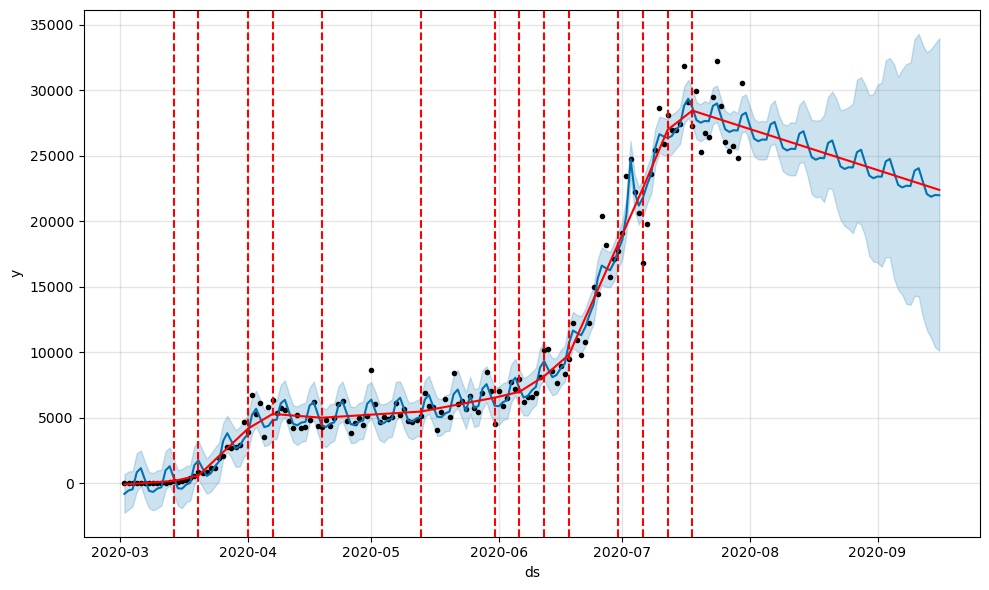

In [311]:
# Visualizing change points
fig = s_tuned_prophet.plot(s_tuned_forecast)
a = add_changepoints_to_plot(fig.gca(), s_tuned_prophet, s_tuned_forecast)